In [15]:
import pandas as pd
import numpy as np
import fastsparsegams
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import time

In [2]:
### input parameters for plots, info about MICE

In [3]:
num_trials = 2
split_seed = 0

In [4]:
subset = False
# subset_seed=1
# subset = f'Random_seed={subset_seed}'
# subset_size=5

In [5]:
num_quantiles = 4
quantiles = np.linspace(0, 1, num_quantiles + 2)[1:-1] #don't take first quantile in the space, because it is 0 and will give a vacuous threshold
                                                       #The last is always true for the training set, so we do not use that either. 

In [6]:
no_external=True

### Dataset Loading

In [7]:
df = pd.read_csv('./fico_full.csv')

In [8]:
if subset: 
    if 'Random' in subset: 
        np.random.seed(subset_seed)
        cols = df.columns[list(np.random.choice(df.shape[1]-1, 5, replace=False)) + [-1]]
        df = df[cols]
    else: 
        df = df[df.columns[[-9, -5, -4, -3, -2, -1]]] #highest missingness prop

In [9]:
if no_external and 'ExternalRiskEstimate' in list(df): 
    df.drop('ExternalRiskEstimate', axis=1, inplace=True)

In [10]:
# for c in df.columns:
#     print(f"Missing rate for {c}", df[df[c] <= -7].shape[0] / df[c].shape[0])

### Utility functions for running experiments

In [11]:
def binarize_according_to_train(train_df, test_df, quantiles_for_binarizing = [0.2, 0.4, 0.6, 0.8, 1], overall_mi_intercept = True, overall_mi_ixn = True, specific_mi_intercept = True, specific_mi_ixn = True):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_binned, train_augmented_binned, test_binned, test_augmented_binned = {}, {}, {}, {}
    train_no_missing, test_no_missing = {}, {}
    for c in train_df.columns:
        if c == 'PoorRiskPerformance':
            continue
        missing_col_name = f'{c} missing'
        missing_row_train = np.zeros(n_train)
        missing_row_test = np.zeros(n_test)
        for v in list(train_df[c].quantile(quantiles_for_binarizing).unique()) + [-7, -8, -9]:
            if v in [-7, -8, -9]:

                if specific_mi_intercept:
                    new_col_name = f'{c} == {v}'
    
                    new_row_train = np.zeros(n_train)
                    new_row_train[train_df[c] == v] = 1
                    train_binned[new_col_name] = new_row_train
                    train_augmented_binned[new_col_name] = new_row_train
                    
                    new_row_test = np.zeros(n_test)
                    new_row_test[test_df[c] == v] = 1
                    test_binned[new_col_name] = new_row_test
                    test_augmented_binned[new_col_name] = new_row_test

                missing_row_train[train_df[c] == v] = 1
                missing_row_test[test_df[c] == v] = 1
            else:
                new_col_name = f'{c} <= {v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] <= v] = 1
                train_no_missing[new_col_name] = new_row_train
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] <= v] = 1
                test_no_missing[new_col_name] = new_row_test
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test

        if overall_mi_intercept: 
            train_binned[missing_col_name] = missing_row_train
            train_augmented_binned[missing_col_name] = missing_row_train
        
            test_binned[missing_col_name] = missing_row_test
            test_augmented_binned[missing_col_name] = missing_row_test
    
    for c_outer in train_df.columns:
        if c_outer == 'PoorRiskPerformance':
            continue
        for c_inner in train_df.columns:
            for v in train_df[c_inner].quantile(quantiles_for_binarizing).unique():
                if (v in [-7, -8, -9]) or c_inner == 'PoorRiskPerformance':
                    continue
                else:
                    missing_ixn_name = f'{c_outer} missing & {c_inner} <= {v}'
                    missing_ixn_row_train = np.zeros(n_train)
                    missing_ixn_row_test = np.zeros(n_test)
                    for m_val in [-7, -8, -9]:
                        if specific_mi_ixn: 
                            new_col_name = f'{c_outer}_missing_{m_val} & {c_inner} <= {v}'
    
                            new_row_train = np.zeros(n_train)
                            new_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                            train_augmented_binned[new_col_name] = new_row_train
    
                            new_row_test = np.zeros(n_test)
                            new_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1
                            test_augmented_binned[new_col_name] = new_row_test

                        missing_ixn_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                        missing_ixn_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1

                    if overall_mi_ixn: 
                        train_augmented_binned[missing_ixn_name] = missing_ixn_row_train
                        test_augmented_binned[missing_ixn_name] = missing_ixn_row_test
                        
    train_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_no_missing['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_no_missing['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_augmented_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_augmented_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    return pd.DataFrame(train_no_missing), pd.DataFrame(train_binned), pd.DataFrame(train_augmented_binned), \
         pd.DataFrame(test_no_missing), pd.DataFrame(test_binned), pd.DataFrame(test_augmented_binned)

In [12]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test, col_names): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    missing_coeffs = np.zeros((len(model.lambda_0[0])))
    inter_coeffs = np.zeros((len(model.lambda_0[0])))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_test.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        cur_col_names = col_names[(model.coeff(lambda_0=lamby).toarray().flatten()[1:] != 0)]
        missing_coeffs[i] = sum(['-' in c for c in cur_col_names])
        inter_coeffs[i] = sum(['&' in c for c in cur_col_names])
        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs, missing_coeffs, inter_coeffs

In [13]:
# recover objective from probs
#uses mean rather than sum
def objective(probs, y): 
    return np.exp(np.log(probs/(1 - probs))*-1/2*y).mean(axis=1)

### Running Trials

In [17]:
folds = KFold(n_splits=num_trials, shuffle=True, random_state=split_seed)

In [43]:
lambda_grid = [[10, 1, 0.1]]#, 0.01, 0.001]]

In [44]:
trainacc_aug = np.zeros((len(lambda_grid[0]), num_trials))
testacc_aug = np.zeros((len(lambda_grid[0]), num_trials))
num_terms_aug = np.zeros((len(lambda_grid[0]), num_trials))

trainacc_indicator = np.zeros((len(lambda_grid[0]), num_trials))
testacc_indicator = np.zeros((len(lambda_grid[0]), num_trials))
num_terms_indicator = np.zeros((len(lambda_grid[0]), num_trials))

trainacc_no_missing = np.zeros((len(lambda_grid[0]), num_trials))
testacc_no_missing = np.zeros((len(lambda_grid[0]), num_trials))
num_terms_no_missing = np.zeros((len(lambda_grid[0]), num_trials))

In [62]:
for trial_idx, (train_index, test_index) in enumerate(folds.split(df)): 
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    train_no_missing, train_binned, train_binned_augmented, test_no_missing, test_binned, test_binned_augmented = binarize_according_to_train(train_df, test_df, quantiles_for_binarizing = quantiles)
    X_indicator_train = train_binned[train_binned.columns[:-1]].values
    y_train = train_binned['PoorRiskPerformance'].values
    X_indicator_test = test_binned[test_binned.columns[:-1]].values
    y_test = test_binned['PoorRiskPerformance'].values
    X_no_missing_train = train_no_missing[train_no_missing.columns[:-1]].values
    X_no_missing_test = test_no_missing[test_no_missing.columns[:-1]].values
    X_aug_train = train_binned_augmented[train_binned_augmented.columns[:-1]].values
    X_aug_test = test_binned_augmented[test_binned_augmented.columns[:-1]].values


    # run fastsparse on these 3 datasets
    model_aug = fastsparsegams.fit(X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", algorithm="CDPSI", lambda_grid=lambda_grid, num_lambda=None, num_gamma=None)
    model_indicator = fastsparsegams.fit(X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", algorithm="CDPSI", lambda_grid=lambda_grid, num_lambda=None, num_gamma=None)
    model_no_missing = fastsparsegams.fit(X_no_missing_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", algorithm="CDPSI", lambda_grid=lambda_grid, num_lambda=None, num_gamma=None)
    
    # evaluate models
    train_probs_aug, test_probs_aug, coeff_aug, missing_coeff_aug, inter_coeffs = eval_model(model_aug, X_aug_train, 
                                                                            X_aug_test, train_binned_augmented.columns[:-1])
    trainacc_aug[:, trial_idx] = ((train_probs_aug > 0.5) == y_train).mean(axis = 1)
    testacc_aug[:, trial_idx] = ((test_probs_aug > 0.5) == y_test).mean(axis = 1)
    num_terms_aug[:, trial_idx] = (coeff_aug != 0).sum(axis=1)
    
    train_probs_indicator, test_probs_indicator, coeff_indicator, missing_coeff_indicator, _ = eval_model(model_indicator, 
                                                                                                    X_indicator_train, 
                                                                                                    X_indicator_test,
                                                                                                    train_binned.columns[:-1])
    trainacc_indicator[:, trial_idx] = ((train_probs_indicator > 0.5) == y_train).mean(axis=1)
    testacc_indicator[:, trial_idx] = ((test_probs_indicator > 0.5) == y_test).mean(axis=1)
    num_terms_indicator[:, trial_idx] = (coeff_indicator != 0).sum(axis=1)
    
    train_probs_no_missing, test_probs_no_missing, coeff_no_missing, missing_coeff_no_missing, _ = eval_model(model_no_missing, X_no_missing_train, X_no_missing_test, train_no_missing.columns[:-1])
    trainacc_no_missing[:, trial_idx] = ((train_probs_no_missing > 0.5) == y_train).mean(axis=1)
    testacc_no_missing[:, trial_idx] = ((test_probs_no_missing > 0.5) == y_test).mean(axis=1)
    num_terms_no_missing[:, trial_idx] = (coeff_no_missing != 0).sum(axis=1)

In [88]:
#currently gives min/max errors with a center mean; other options like standard error should also work. 
def errors(accs):
    lower_error = (accs.mean(axis=1)[:, np.newaxis] - accs).max(axis=1)[np.newaxis, :]
    upper_error = (accs - accs.mean(axis=1)[:, np.newaxis]).max(axis=1)[np.newaxis, :]
    return np.concatenate([lower_error, upper_error], axis=0)

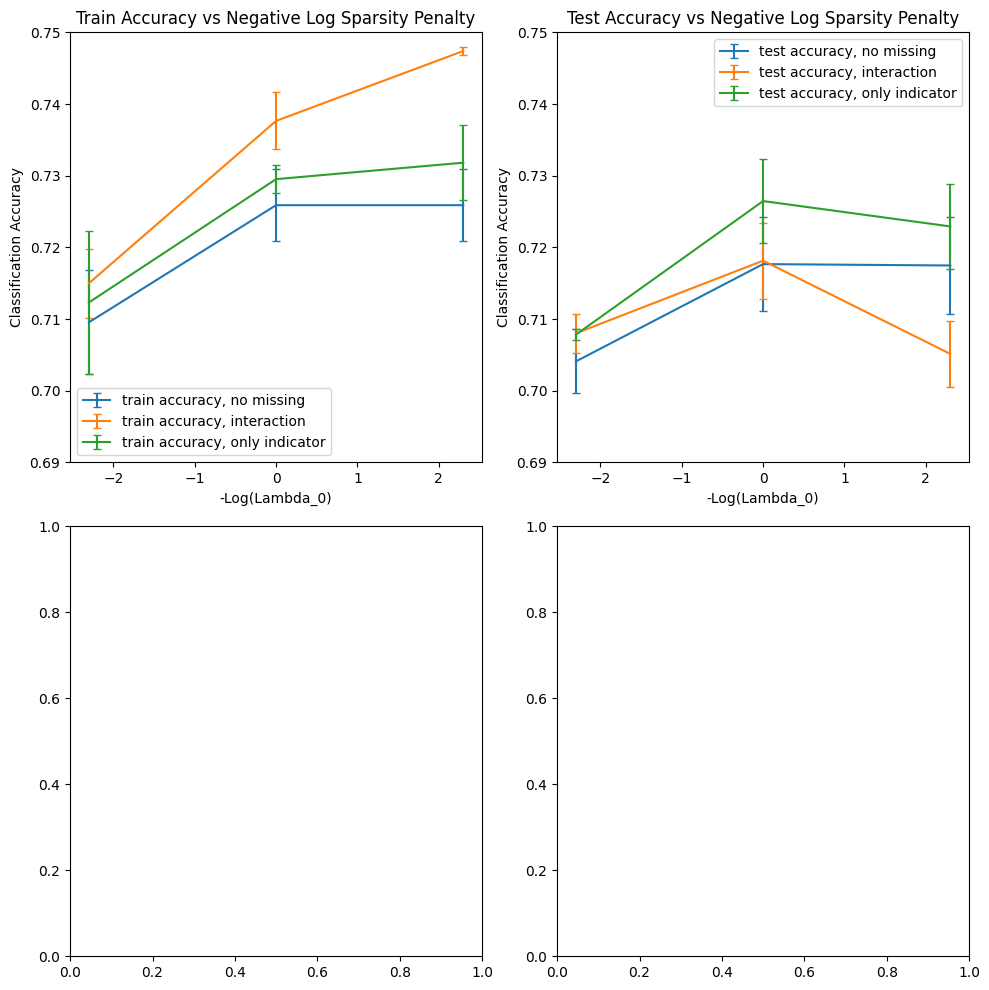

In [106]:
## Plot results

nllambda = [-np.log(x) for x in lambda_grid[0]]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax = axs[0, 0]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_title('Train Accuracy vs Negative Log Sparsity Penalty')
ax.errorbar(nllambda, trainacc_no_missing.mean(axis=1), yerr = errors(trainacc_no_missing), capsize=3 , label='train accuracy, no missing')
ax.errorbar(nllambda, trainacc_aug.mean(axis=1), yerr=errors(trainacc_aug), capsize=3, label='train accuracy, interaction')
ax.errorbar(nllambda, trainacc_indicator.mean(axis=1), yerr=errors(trainacc_indicator), capsize=3, label='train accuracy, only indicator')
ax.set_ylabel('Classification Accuracy')
ax.set_xlabel('-Log(Lambda_0)')
ax.legend()
ax.set_ylim([0.69, 0.75])
# ax.set_ylim([0.5, 0.62])

# ax = axs[1, 0]
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# ax.set_title('Unregularized Train Objective vs # Nonzero Coefficients')#\n (Other than intercept)
# ax.plot(nllambda, objective(train_probs_no_missing, y_train)[num_terms_no_missing > 0], label='train obj, no missing')
# ax.plot(nllambda, objective(train_probs_aug, y_train)[num_terms_aug > 0], label='train obj, interaction')
# ax.plot(num_terms_indicator[num_terms_indicator > 0], objective(train_probs_indicator, y_train)[num_terms_indicator > 0], label='train obj, only indicator')
# ax.set_ylabel('Unregularized Objective')
# ax.set_xlabel('# Nonzero coefficients')
# ax.legend()
# ax.set_ylim([0.86, 0.95])
# # ax.set_ylim([0.96, 0.98])

ax = axs[0, 1]

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Test Accuracy vs Negative Log Sparsity Penalty')
ax.errorbar(nllambda, testacc_no_missing.mean(axis=1), yerr = errors(testacc_no_missing), capsize=3, label='test accuracy, no missing')
ax.errorbar(nllambda, testacc_aug.mean(axis=1), yerr = errors(testacc_aug), capsize=3, label='test accuracy, interaction')
ax.errorbar(nllambda, testacc_indicator.mean(axis=1), yerr = errors(testacc_indicator), capsize=3, label='test accuracy, only indicator')
ax.set_ylabel('Classification Accuracy')
ax.set_xlabel('-Log(Lambda_0)')
ax.legend()
ax.set_ylim([0.69, 0.75])
# ax.set_ylim([0.5, 0.62])

# ax = axs[1, 1]
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# ax.set_title('Unregularized Test Objective vs # Nonzero Coefficients')#\n (Other than intercept)
# ax.plot(num_terms_no_missing[num_terms_no_missing > 0], objective(test_probs_no_missing, y_test)[num_terms_no_missing > 0], label='test obj, no missing')
# ax.plot(num_terms_aug[num_terms_aug > 0], objective(test_probs_aug, y_test)[num_terms_aug > 0], label='test obj, interaction')
# ax.plot(num_terms_indicator[num_terms_indicator > 0], objective(test_probs_indicator, y_test)[num_terms_indicator > 0], label='test obj, only indicator')
# ax.set_ylabel('Unregularized Objective')
# ax.set_xlabel('# Nonzero coefficients')
# ax.legend()
# ax.set_ylim([0.86, 0.95])
# # ax.set_ylim([0.96, 0.98])

fig.tight_layout()

plt.savefig(f'figs/Dec/fico_comparisons_subset={subset}_quantiles={num_quantiles}_seed={split_seed}_noexternal={no_external}.png')

In [16]:
with open(f'figs/Dec/fico_comparisons_subset={subset}_quantiles={num_quantiles}_seed={split_seed}_noexternal={no_external}.txt', 'w') as outfile: 
    for c in df.columns:
        outfile.write(f"Missing rate for {c}" + str(df[df[c] <= -7].shape[0] / df[c].shape[0]) + '\n')